In [1]:
import time
from threading import Thread
import numpy as np
import visa
import pyvisa
from socket import SOL_SOCKET, SO_KEEPALIVE
from ftplib import FTP, error_temp
import array

import math

In [27]:
class AWG520(object):
    """Controller for the Tektronix AWG520 device.
    
    SCPI commands are issued via gpib.
    See device manual for command documentation.
    File management is done via FTP.
    
    """
    
    def __init__(self, gpib='GPIB0::4::INSTR',
                       ftp='192.168.0.10',
                       socket=('192.168.0.10', 4000)):
        self.socket_addr = socket
        # set ftp parameters
        self.ftp_addr = ftp
        self.ftp_user = '\r'
        self.ftp_pw = '\r'
        self.ftp_cwd = '/main/waves'
        self.ftp_manager = FTPManager(self)
        self.todo = -1
        self.done = -1
        # setup gpib connection
        self.gpib_addr = gpib
        rm = pyvisa.ResourceManager()
        self.gpib = rm.open_resource(self.gpib_addr)
        self.gpib.timeout = 500.0
        
    def __del__(self):
        self.gpib.close()
    
    # ____________
    # File Management
    
    def upload(self, files):
        # allow single files
        if not isinstance(files, (list, tuple)):
            files = [files]
    
        # opens up new ftp connections in separate threads
        self.todo = len(files)
        self.done = 0
        for file in files:
            self.ftp_manager.upload(file)
    
    def delete_all(self):
        """Remove all files from the AWG's CWD.
        """
        self.ftp_manager.delete_all()
        
    # ____________
    # Operation Commands
    
    def tell(self, command):
        """Send a command string to the AWG."""
        self.gpib.write(command)
        
    def ask(self, query):
        """Send a query string to AWG and return the response."""
        self.gpib.write(query)
        try:
            res = self.gpib.read()
        except visa.VisaIOError as e:
            res = ''
            if 'Timeout' in e.message:
                res = 'No response from AWG for: "' + query + '"'
            else:
                raise e
        return res
    def write_file(self, filename, values):
        #values must be in a list, filename as a string
        self.gpib.write_binary_values(f'MMEM:data "{filename}", ', values)
        
    def get_file_data(self, filename):
        #data = self.gpib.query_binary_values(f'MMEM:DATA? "{filename}"')
        awg.gpib.write(f'MMEM:DATA? "{filename}"')
        data = awg.gpib.read_raw()
        return data
    
    def write(self, cmd):
        self.gpib.write(cmd)
        time.sleep(0.1)
    
    def upload_waveform(self, waveform, waveform_name, waveform_ch2 = None, waveform_name_ch2 = None):
        self.set_data_destination(waveform_name)
        self.gpib.term_chars=''
        # transform waveform to something readable by the AWG
        waveform *= 255//max(waveform) # normalize
        waveform_tosend = array.array('B',waveform)
        self.write(':CURVE #%u%u%s' % (len( len(waveform_tosend).__str__() ), len(waveform_tosend), waveform_tosend.tostring()))
        #self.write(f':CURVE #%{len(len(waveform_tosend).__str__())}%{len(waveform_tosend)}%{waveform_tosend.tostring()}')
        self.gpib.term_chars=None
        self.Off()
        self.write(':MODE TRIGGERED')
        self.write(':CH1:WAVEFORM "%s"' % waveform_name)
        if waveform_name_ch2 != None:
            self.set_data_destination(waveform_name_ch2)
            waveform_tosend = array.array('B',waveform_ch2)
            self.write(':CURVE #%u%u%s' % (len( len(waveform_tosend).__str__() ), len(waveform_tosend), waveform_tosend.tostring()))
            self.write(':CH2:WAVEFORM "%s"' % waveform_name_ch2)
            
    def Off(self, channel="NORMAL"):
        self.write("OUTPUT:CH1:%s:STATE OFF" %channel)
        
    def set_data_destination(self, waveform_name):
        self.write(':DATA:DESTINATION "%s"' % waveform_name)
        self.write(':DATA:WIDTH 1') # sets number of bytes per data point for transfer
        
    def run(self):
        self.tell('AWGC:RUN')
    
    def stop(self):
        self.tell('AWGC:STOP')
        
    def force_trigger(self):
        self.tell('*TRG')
    
    def force_event(self, bitcode):
        self.tell('AWGC:EVEN:SOFT %i' % bitcode)
        
    def set_output(self, channel=0b11):
        """Set the output state of specified channels.
        
        channels - int with states encoded on 2 LSB
                   e.g. bit=0b00 closes all, bit=0b11 opens all,
                        bit=0b10 opens OUTP2 and closes OUTP1
        
        """
        for i in [0, 1]:
            stat = channel >> i & 1 
            self.tell('OUTP%i %i' % ((i + 1), stat))
        
    def set_mode(self, mode):
        """Change the output mode.
        
        Options for mode (case-insensitive):
        continuous - 'C', 'CONT'
        triggered  - 'T', 'TRIG'
        gated      - 'G', 'GAT'
        sequence   - 'S', 'SEQ'
        
        """
        look_up = {'C' : 'CONT', 'CON' : 'CONT', 'CONT' : 'CONT',
                   'T' : 'TRIG', 'TRI' : 'TRIG', 'TRIG' : 'TRIG',
                   'G' : 'GAT' , 'GAT' : 'GAT' , 'GATE' : 'GAT' ,
                   'E' : 'ENH' , 'ENH' : 'ENH' , 'ENHA' : 'ENH' ,
                  }
        self.tell('AWGC:RMOD %s' % look_up[mode.upper()])
    
    def set_sampling(self, frequency):
        """ Set the output sampling rate.
        
        """
        frequency *= 1e-9
        self.tell('SOUR:FREQ %.4GGHz' % frequency)
    
    def set_vpp(self, voltage, channel=0b11):
        """ Set output peak-to-peak voltage of specified channel.
            
        """
        if channel & 1 == 1:
            self.tell('SOUR1:VOLT %.4GV' % voltage)
        if channel & 2 == 2:
            self.tell('SOUR2:VOLT %.4GV' % voltage)
    
    def load(self, filename, channel=1, cwd='\waves', block=False):
        """Load sequence or waveform file into RAM, preparing it for output.
        
        Waveforms and single channel sequences can be assigned to each or both
        channels. Double channel sequences must be assigned to channel 1.
        The AWG's file system is case-sensitive.
        
        """
        self.tell('SOUR%i:FUNC:USER "%s/%s"' % (channel, cwd, filename))
        
        # block thread until the operation is complete
        while block:
            try:
                self.ask('*OPC?')
                self.tell('SYST:BEEP')
                block = False
            except visa.VisaIOError as e:
                if not 'Timeout' in e[0]: raise e
    
    def managed_load(self, filename, channel=1, cwd='\waves'):
        self.ftp_manager.load(filename, channel, cwd)
        
    def get_func(self, channel=1):
        res = self.ask('SOUR%i:FUNC:USER?' % channel)
        # res ~ '"/\\waves/0_MAIN.SEQ","MAIN"'
        return res.split(',')[0].split('/')[-1][:-1] # return ~ '0_MAIN.SEQ'
        
    def reset(self):
        """ Reset the AWG settings. """
        self.tell('*RST')
        

class FTPThread(Thread):
    """ Thread, which opens a new FTP connection.
    """
    def __init__(self, awg):
        # emulate state stuff
        class Foo(): pass
        self.file = Foo()
        self.file.state = 'compiling'
        
        self.awg = awg
        super(FTPThread, self).__init__()
        self.daemon = True
        self.file.state = 'ready'
        
    def setup_ftp(self):
        self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
        self.ftp.set_pasv(False)
        self.ftp.login(self.awg.ftp_user, self.awg.ftp_pw)
        self.ftp.cwd(self.awg.ftp_cwd)
        
    def run(self):
        try:
            self.setup_ftp()
            self.task()
            self.ftp.close()
            self.file.state = 'finished'
        except Exception as e:
            try:
                self.ftp.close()
            except AttributeError as a:
                pass
            self.file.state = 'error'
            # dont raise error_temp
            # if not isinstance(e, error_temp):
            raise e
            
    def task(self): pass

class UploadThread(FTPThread):
    
    def __init__(self, awg, file):
        super(UploadThread, self).__init__(awg)
        self.file = file
    
    def task(self):
        self.file.seek(0)
        self.ftp.storbinary('STOR ' + self.file.name, self.file)

class DeleteAllThread(FTPThread):
    
    def task(self):
        filelist = self.ftp.nlst()
        try:
            filelist.remove('.')
            filelist.remove('..')
        except ValueError:
            pass
        self.awg.tell('MMEM:CDIR "%s"' % self.awg.ftp_cwd)
        for file in filelist:
            self.awg.tell('MMEM:DEL "%s"' % file)
            #self.ftp.delete(file)
        time.sleep(0.5)
            
class FTPManager(Thread):
    """ This Thread will prevent/workaround 421 session limit.
        
        It is only able to do to tasks, uploading files and deleting all files.
    """
    
    def __init__(self, awg):
        self.awg = awg
        self.threads = []
        self.clients = 0
        self.max_clients = 1
        self.awg.done = -1
        self.awg.todo = -1
        self.abort = False
        self.pause_set = False
        self.paused = False
        self.load_file = None
        super(FTPManager, self).__init__()
        self.daemon = True
        self.start()
        
    def upload(self, file):
        ut = UploadThread(self.awg, file)
        self.threads.append(ut)
             
    def delete_all(self):
        dt = DeleteAllThread(self.awg)
        self.threads.append(dt)
        
    def load(self, filename, channel=1, cwd='\waves'):
        self.load_file = { 'filename': filename,
                           'channel' : channel,
                           'cwd'     : cwd
                         }
        
    def reset(self):
        self.pause_set = True
        self.threads = []     # really bad practice!!! TODO: make stappable threads - stop and join them
        
        while not self.paused:
            time.sleep(0.1)
        self.clients = 0
        self.awg.done = -1
        self.awg.todo = -1
        self.pause_set = False
        
    def stop(self):
        self.abort = True
        
    def run(self):
        # Event loop 
        while True:
            # check list of threads repeatedly
            for thr in self.threads:
                if self.abort: return
                # ignore running threads
                if not thr.is_alive():
                    
                    # Case DeleteAllThread:
                    if isinstance(thr, DeleteAllThread):
                        # start a DeleteAllThread
                        if thr.file.state == 'ready' and self.clients == 0:
                            thr.start()
                            self.clients += self.max_clients
                            #time.sleep(0.001)
                        # remove finished DeleteAllThread
                        elif thr.file.state == 'finished':
                            self.clients = 0
                            self.threads.remove(thr)
                        # restart failed DeleteAllThread
                        elif thr.file.state == 'error':
                            self.clients = 0
                            self.threads.remove(thr)
                            self.delete_all()
                            
                    # Case UploadThread:
                    elif isinstance(thr, UploadThread):
                        # start new UploadThread
                        if thr.file.state == 'ready' and self.clients < self.max_clients:
                            thr.start()
                            self.clients += 1
                            #time.sleep(0.001)
                        # remove finished UploadThread
                        elif thr.file.state == 'finished':
                            self.clients -= 1
                            self.threads.remove(thr)
                            self.awg.done += 1
                        # restart failed UploadThread
                        elif thr.file.state == 'error':
                            self.clients -= 1
                            thr.file.seek(0)
                            thr.file.state = 'ready'
                            self.upload(thr.file)
                            self.threads.remove(thr)
                # stop threads if abort is set
                time.sleep(0.001)
            # check if there is something to load into RAM
            if len(self.threads) == 0 and self.awg.done != -1 and self.load_file is not None:
                f = self.load_file
                self.awg.load(f['filename'], f['channel'], f['cwd'], block=True)
                self.load_file = None
            if self.pause_set:
                self.paused = True
                while self.pause_set:
                    time.sleep(0.1)
                self.paused = False

In [28]:
awg = AWG520()

In [11]:
awg.reset()

In [63]:
awg.set_mode('C')

In [64]:
awg.set_sampling(1e9)

In [115]:
t = np.linspace(0, 100, 100)
y = np.cos(2*np.pi*0.1*t)
awg.load("1mh.wfm", channel=1, cwd='', block=False)

In [84]:
256*[int(0xFF*0.5)]

[127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,

In [123]:
awg.set_output()

In [135]:
awg.get_func()

'test.seq'

In [55]:
awg.force_trigger()

In [118]:
awg.set_vpp(2)

In [104]:
awg.tell('SOUR1:FUNC:USER "1mh.wfm", "MAIN"')

In [177]:
awg.get_func()

'test.seq'

In [204]:
awg.stop()

In [89]:
awg.ask('MMEM:NAME?')

'"test.set","MAIN"\n'

In [42]:
awg.ask('MMEM:DATA? "TEST2.WFM"')

Traceback (most recent call last):
  File "<ipython-input-33-d7a2bd165c23>", line 61, in ask
    res = self.gpib.read()
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\site-packages\pyvisa\resources\messagebased.py", line 413, in read
    message = self._read_raw().decode(enco)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\site-packages\pyvisa\resources\messagebased.py", line 386, in _read_raw
    chunk, status = self.visalib.read(self.session, size)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\site-packages\pyvisa\ctwrapper\functions.py", line 1584, in read
    ret = library.viRead(session, buffer, count, byref(return_count))
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\site-packages\pyvisa\ctwrapper\highlevel.py", line 188, in _return_handler
    raise errors.VisaIOError(ret_value)
pyvisa.errors.VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  Fil

In [106]:
awg.gpib.query('MMEM:DATA? "test.wfm"')

Traceback (most recent call last):
  File "C:\qudi\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-106-d99f887277c7>", line 1, in <module>
    awg.gpib.query('MMEM:DATA? "test.wfm"')
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\site-packages\pyvisa\resources\messagebased.py", line 564, in query
    return self.read()
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\site-packages\pyvisa\resources\messagebased.py", line 413, in read
    message = self._read_raw().decode(enco)
UnicodeDecodeError: 'ascii' codec can't decode byte 0xbf in position 57: ordinal not in range(128)


In [88]:
awg.tell('MMEM:NAME "test.set", "MAIN";open')

In [65]:
awg.tell('MMEM:DATA "test.wfm", #41024')

In [79]:
awg.ask('MMEM:CATalog? "MAIN"')

'1440423936,852099072,".set,,1899","1mh.wfm,,5042","20mh.wfm,,5042","a.wfm,,55043","aaa.wfm,,2602","b.wfm,,1342","baruch,DIR,512","c250m.wfm,,3882","c250mi.wfm,,3882","clk.wfm,,1322","clock125.wfm,,1322","clock125_a.wfm,,5182","dori,DIR,512","eran,DIR,512","genadyv,DIR,512","itaid,DIR,512","LFM,DIR,512","liorh,DIR,512","liors,DIR,512","offset_meas.set,,1936","Q_test1.wfm,,40043","ramp1.wfm,,10043","ronis,DIR,512","rotem,DIR,512","s100k.wfm,,50043","sin125MHz.wfm,,5042","single.wfm,,1322","startup.set,,2055","TEK00000.BMP,,153718","test.seq,,215","test.set,,1824","test.wfm,,5042","test2.wfm,,1322","vadimg,DIR,512","wait.wfm,,25043","waves,DIR,512","Waves,DIR,512"\n'

In [175]:
awg.tell('MMEM:OPEN "TEST2.WFM", "MAIN";OPEN')

In [82]:
awg.ask('MMEM:MSIS?')

'"MAIN"\n'

In [288]:
awg.gpib.timeout = 500

In [103]:
awg.ask('MMEM:DATA? "test2.wfm"')

Traceback (most recent call last):
  File "C:\qudi\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-103-67fef7d44579>", line 1, in <module>
    awg.ask('MMEM:DATA? "test2.wfm"')
  File "<ipython-input-33-d7a2bd165c23>", line 61, in ask
    res = self.gpib.read()
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\site-packages\pyvisa\resources\messagebased.py", line 413, in read
    message = self._read_raw().decode(enco)
UnicodeDecodeError: 'ascii' codec can't decode byte 0x90 in position 29: ordinal not in range(128)


In [59]:
awg.tell('MMEM:NAME "test.wfm", "MAIN";open')

In [183]:
values = list(range(3))
awg.gpib.write_binary_values('MMEM:DATA "test2.wfm",', values)

(40, <StatusCode.success: 0>)

In [53]:
#query_test= awg.gpib.query_ascii_values('MMEM:DATA? "test3.wfm"', converter = 'x')
#query_test= awg.gpib.read_ascii_values('MMEM:DATA? "test3.wfm"', converter = 'x')
#query_test= awg.gpib.util.from_ascii_block('MMEM:DATA? "test3.wfm"', converter = 'x')
awg.gpib.write('MMEM:DATA? "test3.wfm"')
query_test = awg.gpib.read_raw()
query_test

b'#45042MAGIC 1000\r\n#45000\x00\x00\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

In [8]:
filename = "test99.wfm"
t = np.linspace(0,255, 256)
values = np.sin(t)
awg.write_file(filename, values)
data = awg.get_file_data(filename)

In [12]:
data = b'\x00\x00\x00\x00\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x000\r%\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x000\x8d\xa5\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x00\xc8\xd3%\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x000\r\xa6\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x00|0&\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x00\xc8S\xa6\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x00\x14w&\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x000\x8d\xa6\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x00\xd6\x9e&\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x00|\xb0\xa6\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xc0\xbb\'\xa8\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x80\xc3\xf2(\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x90\xd4H\xa9\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xb0#\x8c)\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x18\xdd\xb3\xa9\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x80\x96\xdb)\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xf4\xa7\x01\xaa\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xa8\x84\x15*\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\\a)\xaa\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x10>=*\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xc4\x1aQ\xaa\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00x\xf7d*\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00,\xd4x\xaa\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00pX\x86*\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xcaF\x90\xaa\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00$5\x9a*\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00~#\xa4\xaa\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xd8\x11\xae*\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x002\x00\xb8\xaa\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x8c\xee\xc1*\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xe6\xdc\xcb\xaa\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00@\xcb\xd5*\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x9a\xb9\xdf\xaa\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xf4\xa7\xe9*\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00N\x96\xf3\xaa\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xa8\x84\xfd*\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x81\xb9\x03\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xae\xb0\x08+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xdb\xa7\r\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x08\x9f\x12+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x005\x96\x13\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00b\x8d\x18+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x8f\x84\x1d\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xbc{"+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xe9r\'\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x16j,+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00Ca1\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00pX6+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x9dO;\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xcaF@+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xf7=E\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00$5J+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00Q,O\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00~#T+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xab\x1aY\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xd8\x11^+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x05\tc\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x002\x00h+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00_\xf7l\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x8c\xeeq+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xb9\xe5v\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xe6\xdc{+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\nj\x80\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xa0\xe5\x82+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x006a\x85\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xcd\xdc\x87+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00dX\x8a\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xfa\xd3\x8c+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x90O\x8f\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\'\xcb\x91+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xbeF\x94\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00T\xc2\x96+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xea=\x99\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x81\xb9\x9b+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x185\x9e\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xae\xb0\xa0+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00D,\xa3\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xdb\xa7\xa5+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00r#\xa8\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x08\x9f\xaa+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x9e\x1a\xad\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x005\x96\xa3+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xcc\x11\x92\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00b\x8d\x80+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xf1\x11^\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x1e\t;+\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00K\x00\x18\xab\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xf0\xee\xe9*\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00J\xdd\xa3\xaa\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00H\x97;*\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xf0\xcf=\xa9\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xa0^\xb9\xa9\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x9c\xd2h*\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xf4z\xba\xaa\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00MF\x00+\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00 O#\xab\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xf3WF+\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xc6`i\xab\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xcc4\x86+\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x006\xb9\x97\xab\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xa0=\xa9+\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\t\xc2\xba\xab\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00rF\xcc+\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xdc\xca\xdd\xab\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00FO\xef+\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xd8i\x00\xac\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x0c,\t,\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00A\xee\x11\xac\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00v\xb0\x1a,\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xaar#\xac\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xdf4,,\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x14\xf74\xac\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00I\xb9=,\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00~{F\xac\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xb2=O,\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xe7\xffW\xac\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x1c\xc2`,\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00P\x84i\xac\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x85Fr,\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xba\x08{\xac\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00w\xe5\x81,\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x92F\x86\xac\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xac\xa7\x8a,\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xc6\x08\x8f\xac\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xe1i\x93,\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xfb\xca\x97\xac\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x16,\x9c,\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x000\x8d\xa0\xac\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00J\xee\xa4,\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00eO\xa9\xac\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x7f\xb0\xad,\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x9a\x11\xb2\xac\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xb4r\xb6,\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xce\xd3\xba\xac\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xe94\xbf,\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x03\x96\xc3\xac\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x1d\xf7\xc7,\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x008X\xcc\xac\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00R\xb9\xd0,\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00l\x1a\xd5\xac\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x87{\xd9,\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xa1\xdc\xdd\xac\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xbc=\xe2,\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xd6\x9e\xe6\xac\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xf0\xff\xea,\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x0ba\xef\xac\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00%\xc2\xf3,\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00@#\xf8\xac\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00Z\x84\xfc,\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xbar\x00\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00G\xa3\x02-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xd4\xd3\x04\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00b\x04\x07-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xef4\t\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00|e\x0b-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\t\x96\r\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x96\xc6\x0f-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00$\xf7\x11\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xb1\'\x14-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00>X\x16\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xcb\x88\x18-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00X\xb9\x1a\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xe6\xe9\x1c-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00s\x1a\x1f\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x00K!-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x8d{#\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x1a\xac%-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xa8\xdc\'\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x005\r*-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xc2=,\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00On.-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xdc\x9e0\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00i\xcf2-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xf7\xff4\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x8407-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x11a9\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x9e\x91;-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00+\xc2=\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xb9\xf2?-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00F#B\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xd3SD-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00`\x84F\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xed\xb4H-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00z\xe5J\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x08\x16M-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x95FO\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00"wQ-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xaf\xa7S\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00<\xd8U-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xca\x08X\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00W9Z-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xe4i\\\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00q\x9a^-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\xfe\xca`\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\x8c\xfbb-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00\x19,e\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xa6\\g-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x003\x8di\xad\x00\x18y\x16?\x00qxs?\x00qxs?\x00\x18y\x16?\x00\xc0\xbdk-\x00\x18y\x16\xbf\x00qxs\xbf\x00qxs\xbf\x00\x18y\x16\xbf\x00'
print(data.decode("utf-8"))
# print(data)

Traceback (most recent call last):
  File "C:\qudi\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-cec930f2d2c1>", line 2, in <module>
    print(data.decode("utf-8"))
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xbf in position 33: invalid start byte
Traceback (most recent call last):
  File "C:\qudi\qudi\logic\jupyterkernel\qzmqkernel.py", line 490, in run_cell
    code_ast = compiler.ast_parse(cell, filename=cell_name)
  File "C:\qudi\qudi\logic\jupyterkernel\compilerop.py", line 103, in ast_parse
    return compile(source, filename, symbol, self.flags | PyCF_ONLY_AST, 1)
  File "<ipython-input-54-60f30c2a4d3f>", line 7
    print "Uploading with the GPIB . . ."
                                        ^
SyntaxError: Missing parentheses in call to 'print'. Did you mean print("Uploading with the GPIB . . .")?
Traceback (most recent call last):
  File "C:\qudi\qudi\logic\jupyterkernel\q

Exception in thread Thread-61:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-62:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\

Exception in thread Thread-71:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-72:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\

Exception in thread Thread-81:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-82:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\

Exception in thread Thread-91:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-92:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\

Exception in thread Thread-101:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-102:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-111:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-112:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-121:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-122:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-131:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-132:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-141:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-142:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-151:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-152:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-161:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-162:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Traceback (most recent call last):
  File "C:\qudi\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-65-ec4dcabca920>", line 1, in <module>
    awg.get_state()
AttributeError: 'AWG520' object has no attribute 'get_state'
Exception in thread Thread-171:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\en

Exception in thread Thread-180:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-181:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-190:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-191:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-200:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-201:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-210:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-211:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-220:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-221:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-230:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-231:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-240:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-241:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-250:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-251:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-260:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-261:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-269:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-270:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-279:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-280:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-289:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-290:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-299:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-300:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-309:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-310:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-319:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-320:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-329:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-330:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-339:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-340:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-349:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-350:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-359:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-360:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-369:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-370:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-379:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-380:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-389:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-390:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-399:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-400:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-409:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-410:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-419:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-420:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-429:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-430:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-439:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-440:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-449:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-450:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-459:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-460:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-469:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-470:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-479:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-480:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-489:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-490:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-499:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-500:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-509:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-510:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-519:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-520:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-529:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-530:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-539:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-540:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-547:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-548:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-559:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-560:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-569:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-570:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-579:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-580:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-589:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-590:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-599:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-600:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-609:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-610:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-619:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-620:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-629:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-630:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-639:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-640:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-649:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-650:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-659:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-660:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-669:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-670:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-679:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-680:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-690:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-691:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-700:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-701:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-710:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-711:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-720:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-721:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-730:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-731:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-741:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-740:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-750:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-751:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-760:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-761:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-770:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-771:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-780:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-781:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-789:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-790:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-799:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-800:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-810:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-811:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-819:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-820:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-829:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-830:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-840:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-841:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-849:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-851:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-860:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-861:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-871:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-870:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-880:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-881:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-890:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-891:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-900:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-901:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-910:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-911:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-920:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-921:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-931:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-930:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-940:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-942:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-950:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-951:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-960:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-961:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-969:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-971:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-980:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-981:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-991:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-992:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qud

Exception in thread Thread-1001:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-1002:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\q

Exception in thread Thread-1011:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-1012:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\q

Exception in thread Thread-1021:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-1023:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\q

Exception in thread Thread-1031:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-1032:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\q

Exception in thread Thread-1040:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-1041:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\q

Exception in thread Thread-1050:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-1051:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\q

Exception in thread Thread-1060:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-1061:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\q

Exception in thread Thread-1070:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-1071:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\q

Traceback (most recent call last):
  File "C:\qudi\qudi\logic\jupyterkernel\qzmqkernel.py", line 490, in run_cell
    code_ast = compiler.ast_parse(cell, filename=cell_name)
  File "C:\qudi\qudi\logic\jupyterkernel\compilerop.py", line 103, in ast_parse
    return compile(source, filename, symbol, self.flags | PyCF_ONLY_AST, 1)
  File "<ipython-input-81-0435cfb37a39>", line 38
    print "ftp error:", sys.exc_info()[0]
                     ^
SyntaxError: invalid syntax
Traceback (most recent call last):
  File "C:\qudi\qudi\logic\jupyterkernel\qzmqkernel.py", line 490, in run_cell
    code_ast = compiler.ast_parse(cell, filename=cell_name)
  File "C:\qudi\qudi\logic\jupyterkernel\compilerop.py", line 103, in ast_parse
    return compile(source, filename, symbol, self.flags | PyCF_ONLY_AST, 1)
  File "<ipython-input-82-0435cfb37a39>", line 38
    print "ftp error:", sys.exc_info()[0]
                     ^
SyntaxError: invalid syntax
Traceback (most recent call last):
  File "C:\qudi\qud

Exception in thread Thread-1091:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-1092:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\q

Exception in thread Thread-1100:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-1102:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\q

Exception in thread Thread-1110:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Traceback (most recent call last):
  File "C:\qudi\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in 

Exception in thread Thread-1120:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-1121:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\q

Traceback (most recent call last):
  File "C:\qudi\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-90-c02d6d0a58c2>", line 1, in <module>
    print(st)
NameError: name 'st' is not defined
Exception in thread Thread-1129:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 7

Exception in thread Thread-1138:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-1139:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\q

Exception in thread Thread-1148:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-1149:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\q

Exception in thread Thread-1157:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-2-8f3004469c67>", line 231, in run
    raise e
  File "<ipython-input-2-8f3004469c67>", line 219, in run
    self.setup_ftp()
  File "<ipython-input-2-8f3004469c67>", line 212, in setup_ftp
    self.ftp = FTP(self.awg.ftp_addr, timeout=2.0)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 117, in __init__
    self.connect(host)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\ftplib.py", line 152, in connect
    source_address=self.source_address)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 724, in create_connection
    raise err
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\socket.py", line 713, in create_connection
    sock.connect(sa)
socket.timeout: timed out

Exception in thread Thread-1158:
Traceback (most recent call last):
  File "C:\Users\PI3\anaconda3\envs\q

In [242]:
y = awg.get_file_data("test.wfm")

In [243]:
len(y)

1260

In [237]:
t = np.linspace(0,255, 256)
values = np.sin(t)

In [238]:
len(values)

256

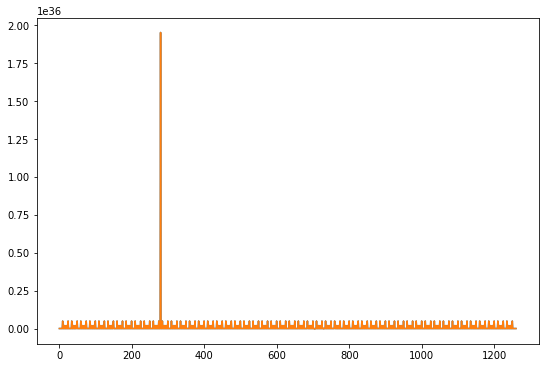

In [259]:
import matplotlib.pyplot as plt
t = np.linspace(0,len(y), len(y))
plt.plot(t, y)
plt.plot(t, query_values)
plt.show()

In [252]:
t = np.linspace(0,len(y), len(y))

In [8]:
query_values_zeroes = awg.get_file_data("test3.wfm")
query_values_100MHz = awg.get_file_data("test.wfm")
query_values_10MHz = awg.get_file_data("test4.wfm")
query_values_ramp = awg.get_file_data("testramp.wfm")

In [35]:
query_values_zeroes = awg.get_file_data("test4.wfm")
query_values_zeroes

b'#45042MAGIC 1000\r\n#45000\x00\x00\x00\x00\x03Q\x98\x80=\x00[W\x00>\x00\xe3\xe0?>\x00\x90\xa8~>\x00z7\x9e>\x00\xd2z\xbc>\x00\xbe\xff\xd9>\x00k\xa8\xf6>\x00\xf2+\t?\x00\x18y\x16?\x008.#?\x00{>/?\x00\xb0\x9d:?\x00[@E?\x00\xbd\x1bO?\x00\xe0%X?\x00\xa2U`?\x00\xbf\xa2g?\x00\xd5\x05n?\x00qxs?\x00\x11\xf5w?\x00-w{?\x00;\xfb}?\x00\xae~\x7f?\x00\x00\x00\x80?\x00\xae~\x7f?\x00;\xfb}?\x00-w{?\x00\x11\xf5w?\x00qxs?\x00\xd5\x05n?\x00\xbf\xa2g?\x00\xa2U`?\x00\xe0%X?\x00\xbd\x1bO?\x00[@E?\x00\xb0\x9d:?\x00{>/?\x008.#?\x00\x18y\x16?\x00\xf2+\t?\x00k\xa8\xf6>\x00\xbe\xff\xd9>\x00\xd2z\xbc>\x00z7\x9e>\x00\x90\xa8~>\x00\xe3\xe0?>\x00[W\x00>\x00Q\x98\x80=\x00\x00-7\xa7\x00Q\x98\x80\xbd\x00[W\x00\xbe\x00\xe3\xe0?\xbe\x00\x90\xa8~\xbe\x00z7\x9e\xbe\x00\xd2z\xbc\xbe\x00\xbe\xff\xd9\xbe\x00k\xa8\xf6\xbe\x00\xf2+\t\xbf\x00\x18y\x16\xbf\x008.#\xbf\x00{>/\xbf\x00\xb0\x9d:\xbf\x00[@E\xbf\x00\xbd\x1bO\xbf\x00\xe0%X\xbf\x00\xa2U`\xbf\x00\xbf\xa2g\xbf\x00\xd5\x05n\xbf\x00qxs\xbf\x00\x11\xf5w\xbf\x00-w{\xbf\x00;\xf

In [22]:
string = b'#45042MAGIC 1000\r\n#45000\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00CLOCK 1.0000000000e+08\r\n\n'
awg.gpib.write_raw(f"MMEM:DATA 'test3.wfm', {string}")

b'#45042MAGIC 1000\r\n#45000\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

In [11]:
file = awg.get_file_data("test.wfm")
file

b'#41024\x00\x00\x00\x00\xa4jW?\xb7\xc7h?\xc3\x81\x10>\xcf\xbdA\xbf\x10|u\xbf\x8c\x0f\x8f\xbeF0(?\x95F}?2\x01\xd3>\xf8D\x0b\xbf\\\xff\x7f\xbf\xd8\\\t\xbf" \xd7>r\x98}?Dy&?\x10h\x93\xbe%\x1ev\xbf\xb3@@\xbfiy\x19>\xc8\xb6i?\x10/V?\x15\x05\x11\xbc\xe7\xa1X\xbf\xfc\xd3g\xbf8\x87\x07\xbe\x087C?\x0e\xd5t?*\xb4\x8a>\xe9\xe3)\xbf\xa4\xef|\xbf\x06\xde\xce\xbeM*\r?9\xfa\x7f?\xf7q\x07?\xc2:\xdb\xbe8\xe5}\xbf\xea\xbe$\xbf\x9f\xbd\x97>K\xbbv?\xbc\xbf>?\xfbm"\xbe(\xa1j\xbf1\xefT\xbf\xa1\x03\x91<\xd0\xd4Y?\x9a\xdbf?\xe8\x13\xfd=V\xacD\xbf")t\xbf\xffU\x86\xbe$\x94+?\xa0\x93|?\xb4\xb6\xca>\xcd\x0c\x0f\xbf\xf4\xef\x7f\xbf^\x84\x05\xbf\xfdP\xdf>\xe7,~?C\x01#?#\x10\x9c\xbe\x7fSw\xbf\xf2:=\xbfK_+>\xd4\x86k?\x0b\xabS?\xce\x81\xd9\xbc[\x03[\xbf\x97\xdee\xbfM\x14\xeb\xbd\xb3\x1dF?Qxs?#\xf5\x81>\xed@-\xbf\x8c2|\xbfQ\x8b\xc6\xben\xec\x10?\x8e\xe0\x7f?\x18\x94\x03?\xbcb\xe3\xbe}o~\xbfW@!\xbf\x86_\xa0>\xbc\xe6w?\\\xb2;?+M4\xbe\xc6gl\xbf\xa7bR\xbf\xd0\xfd\x10=\x82-\\?\xf7\xdcd?\xfb\x0f\xd9=\x17\x8bG\xbf\x9e\xc2r\x

In [67]:
awg.write_file("test3.wfm", query_values_zeroes)

In [121]:
awg.reset()

In [10]:
awg.upload_waveform(256*[int(0xFF*0.5)], "test.wfm")

In [94]:
max(256*[int(0xFF*0.5)])

127

In [34]:
from codecs import BOM_UTF8, BOM_UTF16_BE, BOM_UTF16_LE, BOM_UTF32_BE, BOM_UTF32_LE

BOMS = (
    (BOM_UTF8, "UTF-8"),
    (BOM_UTF32_BE, "UTF-32-BE"),
    (BOM_UTF32_LE, "UTF-32-LE"),
    (BOM_UTF16_BE, "UTF-16-BE"),
    (BOM_UTF16_LE, "UTF-16-LE"),
)

def check_bom(data):
    return [encoding for bom, encoding in BOMS if data.startswith(bom)]

In [37]:
def isUTF8(data):
    try:
        data.decode('UTF-8')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [38]:
isUTF8(query_values_zeroes)

False

In [66]:
awg.write_file("test.wfm", 'MAGIC 1000\r\n#41280b\'\\x00\\x00\\x00\\x00\\x0021\\x8d\\xa5\\x0021\\r\\xa6\\x00\\xca\\xc9S\\xa6\\x0021\\x8d\\xa6\\x00~}\\xb0\\xa6\\x00\\xca\\xc9\\xd3\\xa6\\x00\\x17\\x16\\xf7\\xa6\\x0021\\r\\xa7\\x00X\\xd7\\x1e\\xa7\\x00~}0\\xa7\\x00\\xe9\\x880\\xa8\\x00\\xca\\xc9S\\xa7\\x00\\x08H\\x8d\\\'\\x00\\x17\\x16w\\xa7\\x00\\x0f/B\\xa8\\x0021\\x8d\\xa7\\x00w\\xf7S\\\'\\x00X\\xd7\\x9e\\xa7\\x005\\xd5S\\xa8\\x00~}\\xb0\\xa7\\x00\\xde^\\r\\\'\\x00\\xe9\\x88\\xb0\\xa8\\x00\\\\{e\\xa8\\x00\\xca\\xc9\\xd3\\xa7\\x00\\x8a\\x8c\\x8d&\\x00\\x08H\\r(\\x00\\x82!w\\xa8\\x00\\x17\\x16\\xf7\\xa7\\x00\\xdb\\xb06"\\x00\\x0f/\\xc2\\xa8\\x00\\xd4c\\x84\\xa8\\x0021\\r\\xa8\\x00\\xd9\\xd5\\x8c\\xa6\\x00w\\xf7\\xd3\\\'\\x00\\xe76\\x8d\\xa8\\x00X\\xd7\\x1e\\xa8\\x00\\x85\\x03\\r\\xa7\\x005\\xd5\\xd3\\xa8\\x00\\xfa\\t\\x96\\xa8\\x00~}0\\xa8\\x00\\xc29\\r\\xa9\\x00\\xde^\\x8d\\\'\\x00\\r\\xdd\\x9e\\xa8\\x00\\xe9\\x880\\xa9\\x00[\\x1a\\x8d\\xa7\\x00\\\\{\\xe5\\xa8\\x00\\xbf\\x9f0(\\x00\\xca\\xc9S\\xa8\\x00\\xd5\\x0c\\x16\\xa9\\x00\\x8a\\x8c\\r\\\'\\x004\\x83\\xb0\\xa8\\x00\\x08H\\x8d(\\x00\\xf4\\xb2\\xd3\\xa7\\x00\\x82!\\xf7\\xa8\\x00sS\\r(\\x00\\x17\\x16w\\xa8\\x00\\xe8\\xdf\\x1e\\xa9\\x00\\xdb\\xb0\\xb6"\\x00Z)\\xc2\\xa8\\x00\\x0f/B\\xa9\\x00\\xc7%\\r\\xa8\\x00\\xd4c\\x04\\xa9\\x00M\\x0e\\xd4\\\'\\x0021\\x8d\\xa8\\x00\\xfb\\xb2\\\'\\xa9\\x00\\xd9\\xd5\\x0c\\xa7\\x00\\x80\\xcf\\xd3\\xa8\\x00w\\xf7S(\\x00\\x13r0\\xa8\\x00\\xe76\\r\\xa9\\x00\\xb4u\\x8d\\\'\\x00X\\xd7\\x9e\\xa8\\x00\\x0e\\x860\\xa9\\x00\\x85\\x03\\x8d\\xa7\\x00\\xa6u\\xe5\\xa8\\x005\\xd5S\\xa9\\x00_\\xbeS\\xa8\\x00\\xfa\\t\\x16\\xa9\\x006\\xba\\r\\\'\\x00~}\\xb0\\xa8\\x00!Y9\\xa9\\x00\\xc29\\x8d\\xa9\\x00\\x1ar\\x04)\\x00\\xde^\\r(\\x00\\xac\\nw\\xa8\\x00\\r\\xdd\\x1e\\xa9\\x00p\\xf7\\x7f\\xa9\\x00\\xe9\\x88\\xb0\\xa9\\x00.Ow(\\x00[\\x1a\\r\\xa8\\x00\\xf9`\\x04\\xa9\\x00\\\\{e\\xa9\\x00\\xdfJ\\xa3\\xa9\\x00\\xbf\\x9f\\xb0(\\x00-\\xa8\\x0c\\xa7\\x00\\xca\\xc9\\xd3\\xa8\\x00H\\xffJ\\xa9\\x00\\xd5\\x0c\\x96\\xa9\\x00\\xe7\\x97\\xe5(\\x00\\x8a\\x8c\\x8d\\\'\\x00\\xa2\\xd1\\x9e\\xa8\\x004\\x830\\xa9\\x00\\xcb\\xce\\x88\\xa9\\x00\\x08H\\r)\\x00\\x95\\xb60(\\x00\\xf4\\xb2S\\xa8\\x00\\x1f\\x07\\x16\\xa9\\x00\\x82!w\\xa9\\x00\\xf2\\x1d\\xac\\xa9\\x00sS\\x8d(\\x00H\\x85\\xd3\\xa7\\x00\\x17\\x16\\xf7\\xa8\\x00n\\xa5\\\\\\xa9\\x00\\xe8\\xdf\\x9e\\xa9\\x00\\x9bK\\xc2(\\x00\\xdb\\xb06#\\x00\\xef\\x1d\\xc2\\xa8\\x00Z)B\\xa9\\x00\\xde\\xa1\\x91\\xa9\\x00\\x0f/\\xc2\\xa9\\x00\\xf9;\\xd4\\\'\\x00\\xc7%\\x8d\\xa8\\x00F\\xad\\\'\\xa9\\x00\\xd4c\\x84\\xa9\\x00\\x05\\xf1\\xb4\\xa9\\x00M\\x0eT(\\x00=[0\\xa8\\x0021\\r\\xa9\\x00\\x94Kn\\xa9\\x00\\xfb\\xb2\\xa7\\xa9\\x00N\\xff\\x9e(\\x00\\xd9\\xd5\\x8c\\xa7\\x00;j\\xe5\\xa8\\x00\\x80\\xcfS\\xa9\\x00\\xf1t\\x9a\\xa9\\x00w\\xf7\\xd3(\\x00\\x8f\\x15\\x0e\\\'\\x00\\x13r\\xb0\\xa8\\x00lS9\\xa9\\x00\\xe76\\x8d\\xa9\\x00\\x18\\xc4\\xbd\\xa9\\x00\\xb4u\\r(\\x00\\xd6\\xf3v\\xa8\\x00X\\xd7\\x1e\\xa9\\x00\\xba\\xf1\\x7f\\xa9\\x00\\x0e\\x86\\xb0\\xa9\\x00\\x04fw(\\x00\\x85\\x03\\r\\xa8\\x00D[\\x04\\xa9\\x00\\xa6ue\\xa9\\x00\\x04H\\xa3\\xa9\\x005\\xd5\\xd3\\xa9\\x00\\xd5L\\x0c\\xa7\\x00_\\xbe\\xd3\\xa8\\x00\\x92\\xf9J\\xa9\\x00\\xfa\\t\\x96\\xa9\\x00+\\x97\\xc6\\xa9\\x006\\xba\\x8d\\\'\\x007\\xc6\\x9e\\xa8\\x00~}0\\xa9\\x00\\xf0\\xcb\\x88\\xa9\\x00!Y\\xb9\\xa9\\x00S\\xe6\\xe9\\xa9\\x00\\xc29\\r\\xaa\\x00Z\\x80%\\xaa\\x00\\x1ar\\x84)\\x00\\xd1\\xc9\\\')\\x00\\xde^\\x8d(\\x00\\x9cW\\xd3\\xa7\\x00\\xac\\n\\xf7\\xa8\\x00\\xb8\\x9f\\\\\\xa9\\x00\\r\\xdd\\x9e\\xa9\\x00?j\\xcf\\xa9\\x00p\\xf7\\xff\\xa9\\x00PB\\x18\\xaa\\x00\\xe9\\x880\\xaa\\x00\\xf9\\xc1\\\\)\\x00.O\\xf7(\\x00\\xa5i\\xd4\\\'\\x00[\\x1a\\x8d\\xa8\\x00\\x90\\xa7\\\'\\xa9\\x00\\xf9`\\x84\\xa9\\x00*\\xee\\xb4\\xa9\\x00\\\\{\\xe5\\xa9\\x00F\\x04\\x0b\\xaa\\x00\\xdfJ#\\xaa\\x00\\x11\\xdd\\x88)\\x00\\xbf\\x9f0)\\x00\\xba\\n\\x9f(\\x00-\\xa8\\x8c\\xa7\\x00\\xd0^\\xe5\\xa8\\x00\\xca\\xc9S\\xa9\\x00\\x16r\\x9a\\xa9\\x00H\\xff\\xca\\xa9\\x00y\\x8c\\xfb\\xa9\\x00\\xd5\\x0c\\x16\\xaa\\x00nS.\\xaa\\x00\\xe7\\x97e)\\x00\\x85}\\x04)\\x00\\x8a\\x8c\\r(\\x00\\x00\\xddv\\xa8\\x00\\xa2\\xd1\\x1e\\xa9\\x00\\x05\\xec\\x7f\\xa9\\x004\\x83\\xb0\\xa9\\x00e\\x10\\xe1\\xa9\\x00\\xcb\\xce\\x08\\xaa\\x00d\\x15!\\xaa\\x00\\x08H\\x8d)\\x00\\xadu9)\\x00\\x95\\xb6\\xb0(\\x00|\\xf1\\x0b\\xa7\\x00\\xf4\\xb2\\xd3\\xa8\\x00\\xdd\\xf3J\\xa9\\x00\\x1f\\x07\\x96\\xa9\\x00Q\\x94\\xc6\\xa9\\x00\\x82!\\xf7\\xa9\\x00Z\\xd7\\x13\\xaa\\x00\\xf2\\x1d,\\xaa\\x00\\xd5mn)\\x00sS\\r)\\x00A\\xe40(\\x00H\\x85S\\xa8\\x00\\xb4\\xfb\\x15\\xa9\\x00\\x17\\x16w\\xa9\\x00=\\x18\\xac\\xa9\\x00n\\xa5\\xdc\\xa9\\x00O\\x99\\x06\\xaa\\x00\\xe8\\xdf\\x1e\\xaa\\x00\\x81&7\\xaa\\x00\\x9bKB)\\x00qb\\xc2(\\x00\\xdb\\xb0\\xb6#\\x00\\x19\\x07\\xc2\\xa8\\x00\\xef\\x1dB\\xa9\\x00)\\x9c\\x91\\xa9\\x00Z)\\xc2\\xa9\\x00\\x8b\\xb6\\xf2\\xa9\\x00\\xde\\xa1\\x11\\xaa\\x00w\\xe8)\\xaa\\x00\\x0f/B\\xaa\\x00a)\\x16)\\x00\\xf9;T(\\x00\\x91-0\\xa8\\x00\\xc7%\\r\\xa9\\x00)@n\\xa9\\x00F\\xad\\xa7\\xa9\\x00w:\\xd8\\xa9\\x00\\xd4c\\x04\\xaa\\x00m\\xaa\\x1c\\xaa\\x00\\x05\\xf14\\xaa\\x00\\x89!K)\\x00M\\x0e\\xd4(\\x00@\\xcc\\x0e\\\'\\x00=[\\xb0\\xa8\\x00\\x01H9\\xa9\\x00\'CLOCK 1.0000000000e+09')
awg.write_file("test.wfm", [0, 1, 1, 2])

In [45]:
a = self.gpib.write_values('MMEM:data "TEST.wfm", "MAGIC 1000\r\n#41280[( 0.0000000e+00, 0) ( 1.1241111e-09, 0) ( 2.2482223e-09, 0)\n (-1.1528828e-08, 0) ( 4.4964446e-09, 0) ( 2.0521716e-08, 0)\n (-2.3057655e-08, 0) (-7.0323836e-09, 0) ( 8.9928891e-09, 0)\n (-3.4586485e-08, 0) ( 4.1043432e-08, 0) (-2.5359392e-09, 0)\n (-4.6115311e-08, 0) ( 2.9514606e-08, 0) (-1.4064767e-08, 0)\n ( 6.1565153e-08, 0) ( 1.7985778e-08, 0) (-2.5593595e-08, 0)\n (-6.9172970e-08, 0) ( 6.4569496e-09, 0) ( 8.2086864e-08, 0)\n (-8.0701795e-08, 0) (-5.0718785e-09, 0) ( 7.0558038e-08, 0)\n (-9.2230621e-08, 0) (-1.6600707e-08, 0) ( 5.9029212e-08, 0)\n ( 1.3465913e-07, 0) (-2.8129534e-08, 0) ( 4.7500382e-08, 0)\n ( 1.2313031e-07, 0) (-3.9658364e-08, 0) ( 3.5971556e-08, 0)\n ( 1.1160147e-07, 0) (-5.1187190e-08, 0) ( 2.6286131e-07, 0)\n (-1.3834594e-07, 0) (-6.2716019e-08, 0) ( 1.2913899e-08, 0)\n ( 8.8543814e-08, 0) ( 1.6417373e-07, 0) ( 2.3980365e-07, 0)\n (-1.6140359e-07, 0) (-8.5773671e-08, 0) (-1.0143757e-08, 0)\n ( 6.5486162e-08, 0) ( 1.4111608e-07, 0) ( 2.1674599e-07, 0)\n (-1.8446124e-07, 0) (-1.0883133e-07, 0) (-3.3201413e-08, 0)\n ( 4.2428503e-08, 0) ( 1.1805842e-07, 0) ( 1.9368834e-07, 0)\n ( 2.6931826e-07, 0) (-1.3188898e-07, 0) (-5.6259069e-08, 0)\n ( 1.9370848e-08, 0) ( 9.5000765e-08, 0) ( 1.7063068e-07, 0)\n ( 2.4626061e-07, 0) (-1.5494665e-07, 0) (-7.9316727e-08, 0)\n (-3.6868075e-09, 0) ( 7.1943113e-08, 0) ( 1.4757303e-07, 0)\n ( 2.2320295e-07, 0) ( 2.9883287e-07, 0) (-1.0237438e-07, 0)\n (-2.6744463e-08, 0) ( 5.2572261e-07, 0) ( 1.2451537e-07, 0)\n (-2.7669188e-07, 0) ( 2.7577519e-07, 0) (-1.2543204e-07, 0)\n ( 4.2703505e-07, 0) ( 2.5827799e-08, 0) (-3.7537944e-07, 0)\n ( 1.7708763e-07, 0) (-2.2411960e-07, 0) ( 3.2834745e-07, 0)\n (-7.2859777e-08, 0) ( 4.7960731e-07, 0) ( 7.8400056e-08, 0)\n (-3.2280718e-07, 0) ( 2.2965989e-07, 0) (-1.7154734e-07, 0)\n ( 3.8091972e-07, 0) (-2.0287514e-08, 0) ( 5.3217957e-07, 0)\n ( 1.3097232e-07, 0) (-2.7023492e-07, 0) ( 2.8223215e-07, 0)\n (-1.1897509e-07, 0) ( 4.3349198e-07, 0) ( 3.2284746e-08, 0)\n (-3.6892249e-07, 0) ( 1.8354459e-07, 0) (-2.1766266e-07, 0)\n ( 3.3480441e-07, 0) (-6.6402826e-08, 0) ( 4.8606427e-07, 0)\n ( 8.4857007e-08, 0) (-3.1635022e-07, 0) ( 2.3611685e-07, 0)\n (-1.6509040e-07, 0) ( 3.8737667e-07, 0) (-1.3830564e-08, 0)\n ( 5.3863653e-07, 0) ( 1.3742927e-07, 0) (-2.6377796e-07, 0)\n ( 2.8868911e-07, 0) (-1.1251814e-07, 0) ( 4.3994893e-07, 0)\n ( 3.8741696e-08, 0) ( 5.9120879e-07, 0) ( 1.9000153e-07, 0)\n (-2.1120572e-07, 0) ( 3.4126137e-07, 0) (-5.9945876e-08, 0)\n ( 4.9252122e-07, 0) ( 9.1313957e-08, 0) (-3.0989330e-07, 0)\n ( 2.4257380e-07, 0) (-1.5863345e-07, 0) ( 3.9383363e-07, 0)\n (-7.3736151e-09, 0) ( 5.4509349e-07, 0) ( 1.4388623e-07, 0)\n (-2.5732103e-07, 0) ( 2.9514607e-07, 0) (-1.0606119e-07, 0)\n ( 4.4640589e-07, 0) ( 4.5198647e-08, 0) ( 5.9766575e-07, 0)\n ( 1.9645849e-07, 0) (-2.0474876e-07, 0) (-6.0595602e-07, 0)\n (-5.3488925e-08, 0) ( 4.9897812e-07, 0) ( 1.0514452e-06, 0)\n (-3.0343634e-07, 0) ( 2.4903073e-07, 0) ( 8.0149783e-07, 0)\n (-5.5338376e-07, 0) (-9.1666580e-10, 0) ( 5.5155039e-07, 0)\n ( 1.1040174e-06, 0) (-2.5086408e-07, 0) ( 3.0160300e-07, 0)\n ( 8.5407009e-07, 0) (-5.0081150e-07, 0) ( 5.1655597e-08, 0)\n ( 6.0412265e-07, 0) (-7.5075889e-07, 0) (-1.9829181e-07, 0)\n ( 3.5417526e-07, 0) ( 9.0664236e-07, 0) (-4.4823921e-07, 0)\n ( 1.0422786e-07, 0) ( 6.5669491e-07, 0) (-6.9818662e-07, 0)\n (-1.4571955e-07, 0) ( 4.0674752e-07, 0) ( 9.5921462e-07, 0)\n (-3.9566694e-07, 0) ( 1.5680011e-07, 0) ( 7.0926717e-07, 0)\n (-6.4561436e-07, 0) (-9.3147293e-08, 0) ( 4.5931978e-07, 0)\n ( 1.0117868e-06, 0) (-3.4309468e-07, 0) ( 2.0937237e-07, 0)\n ( 7.6183943e-07, 0) (-5.9304210e-07, 0) (-4.0575028e-08, 0)\n ( 5.1189204e-07, 0) ( 1.0643591e-06, 0) (-2.9052242e-07, 0)\n ( 2.6194465e-07, 0) ( 8.1441169e-07, 0) (-5.4046984e-07, 0)\n ( 1.1997233e-08, 0) ( 5.6446430e-07, 0) ( 1.1169313e-06, 0)\n (-2.3795018e-07, 0) ( 3.1451691e-07, 0) ( 8.6698395e-07, 0)\n (-4.8789758e-07, 0) ( 6.4569491e-08, 0) ( 6.1703656e-07, 0)\n (-7.3784497e-07, 0) (-1.8537791e-07, 0) ( 3.6708917e-07, 0)\n ( 9.1955621e-07, 0) (-4.3532532e-07, 0) ( 1.1714175e-07, 0)\n ( 6.6960882e-07, 0) (-6.8527271e-07, 0) (-1.3280565e-07, 0)\n ( 4.1966143e-07, 0) ( 9.7212853e-07, 0) (-3.8275306e-07, 0)\n ( 1.6971401e-07, 0) ( 7.2218108e-07, 0) (-6.3270045e-07, 0)\n (-8.0233391e-08, 0) ( 4.7223369e-07, 0) ( 1.0247007e-06, 0)\n (-3.3018080e-07, 0) ( 2.2228627e-07, 0) ( 7.7475335e-07, 0)\n (-5.8012819e-07, 0) (-2.7661128e-08, 0) ( 5.2480596e-07, 0)\n ( 1.0772731e-06, 0) (-2.7760854e-07, 0) ( 2.7485854e-07, 0)\n ( 8.2732561e-07, 0) (-5.2755593e-07, 0) ( 2.4911133e-08, 0)\n ( 5.7737822e-07, 0) ( 1.1298453e-06, 0) (-2.2503627e-07, 0)\n ( 3.2743080e-07, 0) ( 8.7989787e-07, 0) (-4.7498369e-07, 0)\n ( 7.7483392e-08, 0) ( 6.2995048e-07, 0) ( 1.1824176e-06, 0)\n (-1.7246401e-07, 0) ( 3.8000306e-07, 0) ( 9.3247013e-07, 0)\n (-4.2241143e-07, 0) ( 1.3005565e-07, 0) ( 6.8252274e-07, 0)\n (-6.7235885e-07, 0) (-1.1989175e-07, 0) ( 4.3257532e-07, 0)\n ( 9.8504245e-07, 0) (-3.6983917e-07, 0) ( 1.8262791e-07, 0)\n ( 7.3509500e-07, 0) (-6.1978659e-07, 0) (-6.7319490e-08, 0)\n ( 4.8514761e-07, 0) ( 1.0376147e-06, 0) (-3.1726691e-07, 0)\n ( 2.3520018e-07, 0) ( 7.8766726e-07, 0) (-5.6721433e-07, 0)\n (-1.4747230e-08, 0) ( 5.3771987e-07, 0) ( 1.0901870e-06, 0)\n (-2.6469465e-07, 0)]CLOCK 1.0000000000e+09"' )

In [44]:
answer = self.gpib.read()
answer 

In [34]:
b=awg.get_file_data('1mh.wfm')

In [35]:
b

b"#45042MAGIC 1000\r\n#45000\x00\x00\x00\x00\x03\xd5\xe2\xcd;\x00\xcb\xe1M<\x00\x0bh\x9a<\x00\xa1\xdd\xcd<\x00\x91\xa8\x00=\x00\x05a\x1a=\x00\xea\x174=\x00\xfc\xccM=\x00\xfb\x7fg=\x00Q\x98\x80=\x00Xo\x8d=\x00\xf1D\x9a=\x00\xfb\x18\xa7=\x00T\xeb\xb3=\x00\xdc\xbb\xc0=\x00q\x8a\xcd=\x00\xf3V\xda=\x00@!\xe7=\x006\xe9\xf3=\x00[W\x00>\x00\xcf\xb8\x06>\x00\xe6\x18\r>\x00\x90w\x13>\x00\xbd\xd4\x19>\x00[0 >\x00[\x8a&>\x00\xad\xe2,>\x00?93>\x00\x01\x8e9>\x00\xe3\xe0?>\x00\xd51F>\x00\xc6\x80L>\x00\xa6\xcdR>\x00d\x18Y>\x00\xf1`_>\x00<\xa7e>\x005\xebk>\x00\xcb,r>\x00\xefkx>\x00\x90\xa8~>\x00Oq\x82>\x00\x05\x8d\x85>\x00a\xa7\x88>\x00[\xc0\x8b>\x00\xec\xd7\x8e>\x00\x0b\xee\x91>\x00\xb1\x02\x95>\x00\xd6\x15\x98>\x00p'\x9b>\x00z7\x9e>\x00\xeaE\xa1>\x00\xb9R\xa4>\x00\xde]\xa7>\x00Sg\xaa>\x00\x0fo\xad>\x00\nu\xb0>\x00<y\xb3>\x00\x9e{\xb6>\x00(|\xb9>\x00\xd2z\xbc>\x00\x95w\xbf>\x00hr\xc2>\x00Dk\xc5>\x00!b\xc8>\x00\xf8V\xcb>\x00\xc1I\xce>\x00t:\xd1>\x00\t)\xd4>\x00z\x15\xd7>\x00\xbe\xff\xd9>\x00\xcf\xe7\xd

In [23]:
a

b'#41024\x00\x00\x00\x00\xa4jW?\xb7\xc7h?\xc3\x81\x10>\xcf\xbdA\xbf\x10|u\xbf\x8c\x0f\x8f\xbeF0(?\x95F}?2\x01\xd3>\xf8D\x0b\xbf\\\xff\x7f\xbf\xd8\\\t\xbf" \xd7>r\x98}?Dy&?\x10h\x93\xbe%\x1ev\xbf\xb3@@\xbfiy\x19>\xc8\xb6i?\x10/V?\x15\x05\x11\xbc\xe7\xa1X\xbf\xfc\xd3g\xbf8\x87\x07\xbe\x087C?\x0e\xd5t?*\xb4\x8a>\xe9\xe3)\xbf\xa4\xef|\xbf\x06\xde\xce\xbeM*\r?9\xfa\x7f?\xf7q\x07?\xc2:\xdb\xbe8\xe5}\xbf\xea\xbe$\xbf\x9f\xbd\x97>K\xbbv?\xbc\xbf>?\xfbm"\xbe(\xa1j\xbf1\xefT\xbf\xa1\x03\x91<\xd0\xd4Y?\x9a\xdbf?\xe8\x13\xfd=V\xacD\xbf")t\xbf\xffU\x86\xbe$\x94+?\xa0\x93|?\xb4\xb6\xca>\xcd\x0c\x0f\xbf\xf4\xef\x7f\xbf^\x84\x05\xbf\xfdP\xdf>\xe7,~?C\x01#?#\x10\x9c\xbe\x7fSw\xbf\xf2:=\xbfK_+>\xd4\x86k?\x0b\xabS?\xce\x81\xd9\xbc[\x03[\xbf\x97\xdee\xbfM\x14\xeb\xbd\xb3\x1dF?Qxs?#\xf5\x81>\xed@-\xbf\x8c2|\xbfQ\x8b\xc6\xben\xec\x10?\x8e\xe0\x7f?\x18\x94\x03?\xbcb\xe3\xbe}o~\xbfW@!\xbf\x86_\xa0>\xbc\xe6w?\\\xb2;?+M4\xbe\xc6gl\xbf\xa7bR\xbf\xd0\xfd\x10=\x82-\\?\xf7\xdcd?\xfb\x0f\xd9=\x17\x8bG\xbf\x9e\xc2r\x

In [36]:
awg.gpib.close()

Traceback (most recent call last):
  File "C:\qudi\qudi\logic\jupyterkernel\qzmqkernel.py", line 490, in run_cell
    code_ast = compiler.ast_parse(cell, filename=cell_name)
  File "C:\qudi\qudi\logic\jupyterkernel\compilerop.py", line 103, in ast_parse
    return compile(source, filename, symbol, self.flags | PyCF_ONLY_AST, 1)
  File "<ipython-input-140-dc57082eea01>", line 310
    def get_file_data('1mh.wfm')
                              ^
SyntaxError: invalid syntax


Traceback (most recent call last):
  File "C:\qudi\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-150-4b347c24dd9f>", line 1, in <module>
    a=awg.get_file_data("1mh.wfm")
AttributeError: 'AWG520' object has no attribute 'get_file_data'
Traceback (most recent call last):
  File "C:\qudi\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-151-4b347c24dd9f>", line 1, in <module>
    a=awg.get_file_data("1mh.wfm")
AttributeError: 'AWG520' object has no attribute 'get_file_data'
Traceback (most recent call last):
  File "C:\qudi\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-153-551a1d4ec0e9>", line 1, in <module>
    b=awg.get_file_data("1mh.wfm")
AttributeError: 'AWG520' object has no attribute 'get_file_data'
Traceba